**Autor: Remberto Lòpez**

## Directorio

1. **Funciones principales utilizadas**

   * Carga y preprocesamiento de datos
   * Entrenamiento y validación de modelos
   * Gráfico de *loss* de entrenamiento y validación
   * Cálculo de métricas de evaluación
   * Guardado de resultados (gráficos y métricas)

2. **Modelos evaluados**

   * CNN profunda (resolución 32×32) evaluada con **Adam**
   * CNN profunda (resolución 96×96) evaluada con **Adam**
   * CNN profunda regularizada (resolución 96×96) evaluada con **Adam** y distintas tasas de aprendizaje
   * CNN profunda regularizada final (resolución 96×96) evaluada con **Adam**

3. **Modelo preentrenado ResNet18**

   * *Fine-tuning* del modelo
   * Evaluación de métricas


# Librerias usadas (**para todo el codigo**)

In [ ]:
import torch
from torchvision import models
from torchvision import transforms, datasets
import PIL
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import csv
import os
import torch.optim as optim
import copy
import random

# 1. Funciones Principales

## 1.1 Carga y Preprocesamiento de Datos

Dado que el nombre de cada carpeta corresponde a la etiqueta (*label*) de sus imágenes, durante la carga de datos se aprovecha esta estructura para generar directamente los conjuntos de **entrenamiento**, **validación** y **prueba** (*Train–Val–Test*).

En este proceso también se aplican las transformaciones necesarias, incluyendo: **estandarización**, **aumento de datos** (*data augmentation*) y definición del **tamaño de los lotes** (*batch size*).

In [ ]:
def cargar_datos(resolucion):
    train_transform = transforms.Compose([
        transforms.Resize((resolucion, resolucion)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    valid_test_transform = transforms.Compose([
        transforms.Resize((resolucion, resolucion)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    dataset_full = datasets.ImageFolder(root='/kaggle/input/dogs-cats-images/dataset/training_set', transform=None)

    train_size = int(0.85 * len(dataset_full))
    valid_size = len(dataset_full) - train_size
    dataset_train, dataset_valid = random_split(dataset_full, [train_size, valid_size])

    dataset_train.dataset.transform = train_transform
    dataset_valid.dataset.transform = valid_test_transform

    train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)
    valid_loader = DataLoader(dataset_valid, batch_size=32, shuffle=False, num_workers=2)

    dataset_test = datasets.ImageFolder(root='/kaggle/input/dogs-cats-images/dataset/test_set', transform=valid_test_transform)
    test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=2)

    return train_loader, valid_loader, test_loader


## 1.2 Función de Entrenamiento

Para mantener una estructura coherente y reutilizable en todos los experimentos, se implementa una función dedicada al proceso de entrenamiento.

Esta función centraliza las operaciones necesarias, facilitando la ejecución y comparación de modelos bajo distintos parámetros y configuraciones.


In [ ]:
def entrenar_y_validar(model, train_loader, valid_loader, optimizer, criterion, device, num_epochs, model_name):
    # Inicializamos listas para almacenar las pérdidas por época
    train_losses = []
    valid_losses = []

    for epoch in range(1, num_epochs + 1):
        # Inicializamos las pérdidas acumuladas para cada época
        train_loss = 0.0
        valid_loss = 0.0

        # Fase de entrenamiento
        model.train()
        for data, target in train_loader:
            # Mover tensores al dispositivo adecuado (CPU o GPU)
            data, target = data.to(device), target.to(device)

            # Limpiar los gradientes de los parámetros optimizados
            optimizer.zero_grad()

            # Paso hacia adelante: calcular las predicciones del modelo
            output = model(data)

            # Calcular la pérdida
            loss = criterion(output, target)

            # Paso hacia atrás: calcular los gradientes de la pérdida con respecto a los parámetros del modelo
            loss.backward()

            # Realizar un paso de optimización (actualización de parámetros)
            optimizer.step()

            # Acumular la pérdida de entrenamiento
            train_loss += loss.item() * data.size(0)

        # Fase de validación
        model.eval()
        with torch.no_grad():  # No necesitamos gradientes en la validación
            for data, target in valid_loader:
                # Mover tensores al dispositivo adecuado (CPU o GPU)
                data, target = data.to(device), target.to(device)

                # Realizar la predicción del modelo
                output = model(data)

                # Calcular la pérdida
                loss = criterion(output, target)

                # Acumular la pérdida de validación
                valid_loss += loss.item() * data.size(0)

        # Calcular las pérdidas promedio de entrenamiento y validación
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)

        # Almacenar las pérdidas de cada época
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Mostrar estadísticas de entrenamiento y validación por época
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

    # Graficar las pérdidas de entrenamiento y validación por época
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    plt.title("Loss por época")
    plt.show()

    guardar_grafico_loss(train_losses, valid_losses, model_name)

In [ ]:
# CONFIGURACION DEVICE
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1.3 Función de Cálculo de Métricas

Con el objetivo de mantener la modularidad y la reutilización del código, se implementa una función específica para el cálculo de métricas de evaluación.
Esta función permite evaluar de forma consistente cualquier modelo entrenado, generando indicadores clave de rendimiento y facilitando la comparación objetiva entre diferentes configuraciones y arquitecturas.

In [ ]:
def calcular_metricas(model, test_loader, device):
    model.eval()  # Ponemos el modelo en modo evaluación
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No necesitamos gradientes en la evaluación
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)  # Clase con mayor probabilidad
            all_preds.extend(predicted.cpu().numpy())  # Guardamos las predicciones
            all_labels.extend(target.cpu().numpy())   # Guardamos las etiquetas reales

    # Calculamos las métricas
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    precision = precision_score(all_labels, all_preds, average='weighted')  # promedio ponderado para clases desbalanceadas
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Mostramos las métricas
    print(f'Acurracy: {accuracy:.2f}%')
    print(f'Precision (promedio ponderado): {precision:.2f}')
    print(f'Recall (promedio ponderado): {recall:.2f}')
    print(f'F1-score (promedio ponderado): {f1:.2f}')
    print('Matriz de Confusión:')
    print(conf_matrix)

    return accuracy, precision, recall, f1, conf_matrix

## 1.4 Funciones para Guardar Resultados

Para asegurar la trazabilidad de los experimentos y facilitar su análisis posterior, se implementan funciones destinadas al guardado automático de los resultados obtenidos.
Estas funciones permiten almacenar tanto los gráficos generados durante el entrenamiento como las métricas de evaluación en formatos organizados, garantizando así una correcta documentación y la posibilidad de replicar o comparar modelos en el futuro.

In [ ]:
def guardar_grafico_loss(train_losses, valid_losses, model_name, carpeta="resultados"):
    # Crear la carpeta antes de todo
    os.makedirs(carpeta, exist_ok=True)

    plt.figure()
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    plt.title(f"Loss por época - {model_name}")

    # Guardar imagen
    nombre_archivo = os.path.join(carpeta, f"{model_name}_loss.png")
    plt.savefig(nombre_archivo)
    plt.close()  # Cierra la figura para liberar memoria

In [ ]:
def guardar_metricas_csv(model_name, accuracy, precision, recall, f1, conf_matrix, filename='resultados/resultados_metricas.csv'):
    # Crear carpeta si no existe
    carpeta = os.path.dirname(filename)
    if carpeta and not os.path.exists(carpeta):
        os.makedirs(carpeta, exist_ok=True)

    # Comprobar si el archivo existe para poner encabezados
    file_exists = os.path.isfile(filename)

    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['Modelo', 'Accuracy', 'Precisión ponderada', 'Recall ponderado', 'F1 ponderado', 'Matriz de Confusión'])
        writer.writerow([model_name, accuracy, precision, recall, f1, conf_matrix.tolist()])

# 2. Evaluación de Modelos

El proceso de evaluación comienza con una CNN profunda entrenada desde cero usando imágenes con resolución de 32x32, donde se compararán distintos optimizadores para analizar su desempeño.
Posteriormente, se aumentará la resolución a 96x96 para evaluar si esta mejora los resultados.
Con el optimizador que arroje mejores métricas, se explorarán diferentes tasas de aprendizaje para optimizar aún más el rendimiento.
Finalmente, con toda esta retroalimentación, se construirá un modelo final que busque alcanzar el mejor balance entre alta precisión y bajo sobreajuste (overfitting).

## 2.1 Modelo Inicial: CNN Profunda para una resoluciòn de 32*32

In [ ]:
class DEEP_CNN(nn.Module):
    def __init__(self):
        super(DEEP_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (32, 32, 32)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),  # (32, 16, 16)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  # (64, 8, 8)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),  # (128, 4, 4)

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),  # (256, 2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
# CARGA DE DATOS
train_loader_32, valid_loader_32, test_loader_32 = cargar_datos(32)

### 2.1.1 Usando ADAM como optimizador

Epoch: 1 	Training Loss: 0.616878 	Validation Loss: 0.555523
Epoch: 2 	Training Loss: 0.515427 	Validation Loss: 0.503449
Epoch: 3 	Training Loss: 0.461382 	Validation Loss: 0.488909
Epoch: 4 	Training Loss: 0.387710 	Validation Loss: 0.504470
Epoch: 5 	Training Loss: 0.319859 	Validation Loss: 0.596735
Epoch: 6 	Training Loss: 0.254191 	Validation Loss: 0.516106
Epoch: 7 	Training Loss: 0.185423 	Validation Loss: 0.570762
Epoch: 8 	Training Loss: 0.148220 	Validation Loss: 0.761962
Epoch: 9 	Training Loss: 0.111818 	Validation Loss: 0.844199
Epoch: 10 	Training Loss: 0.098662 	Validation Loss: 0.792630
Epoch: 11 	Training Loss: 0.078542 	Validation Loss: 0.755666
Epoch: 12 	Training Loss: 0.057633 	Validation Loss: 0.899270
Epoch: 13 	Training Loss: 0.043273 	Validation Loss: 1.279923
Epoch: 14 	Training Loss: 0.046816 	Validation Loss: 1.045006
Epoch: 15 	Training Loss: 0.043066 	Validation Loss: 1.068287
Epoch: 16 	Training Loss: 0.028829 	Validation Loss: 1.213329
Epoch: 17 	Traini

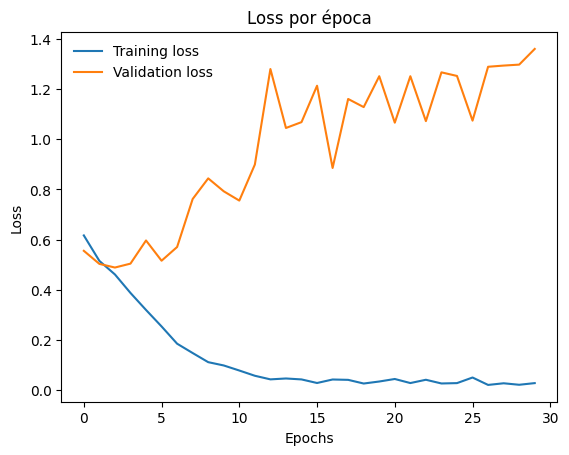

Acurracy: 78.55%
Precision (promedio ponderado): 0.79
Recall (promedio ponderado): 0.79
F1-score (promedio ponderado): 0.79
Matriz de Confusión:
[[767 233]
 [196 804]]


In [ ]:
model_profundo_32_adam = DEEP_CNN().to(device)

entrenar_y_validar(
    model_profundo_32_adam,
    train_loader_32,
    valid_loader_32,
    torch.optim.Adam(model_profundo_32_adam.parameters(), lr=1e-3),
    nn.CrossEntropyLoss(),
    device,
    30,
    "Modelo_Profundo_ADAM_32"
)

accuracy, precision, recall, f1, conf_matrix = calcular_metricas(model_profundo_32_adam, test_loader_32, device)
guardar_metricas_csv("model_profundo_32_adam", accuracy, precision, recall, f1, conf_matrix)

## 2.2 CNN Profunda con Resolucion 96*96

In [ ]:
class DEEP_CNN_96(nn.Module):
    def __init__(self):
        super(DEEP_CNN_96, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (32, 96, 96)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),  # (32, 48, 48)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  # (64, 24, 24)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),  # (128, 12, 12)

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),  # (256, 6, 6)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
# CARGA DE DATOS
train_loader_96, valid_loader_96, test_loader_96 = cargar_datos(96)

### 2.2.1 Usando ADAM como optimizador

Epoch: 1 	Training Loss: 0.752222 	Validation Loss: 0.579702
Epoch: 2 	Training Loss: 0.572378 	Validation Loss: 0.528300
Epoch: 3 	Training Loss: 0.506397 	Validation Loss: 0.503691
Epoch: 4 	Training Loss: 0.448167 	Validation Loss: 0.434931
Epoch: 5 	Training Loss: 0.382191 	Validation Loss: 0.397871
Epoch: 6 	Training Loss: 0.321741 	Validation Loss: 0.383411
Epoch: 7 	Training Loss: 0.256187 	Validation Loss: 0.420986
Epoch: 8 	Training Loss: 0.205037 	Validation Loss: 0.454425
Epoch: 9 	Training Loss: 0.165405 	Validation Loss: 0.352445
Epoch: 10 	Training Loss: 0.119285 	Validation Loss: 0.408092
Epoch: 11 	Training Loss: 0.086103 	Validation Loss: 0.563232
Epoch: 12 	Training Loss: 0.069175 	Validation Loss: 0.528067
Epoch: 13 	Training Loss: 0.088366 	Validation Loss: 0.607725
Epoch: 14 	Training Loss: 0.077389 	Validation Loss: 0.511459
Epoch: 15 	Training Loss: 0.063596 	Validation Loss: 0.555385
Epoch: 16 	Training Loss: 0.054041 	Validation Loss: 0.830942
Epoch: 17 	Traini

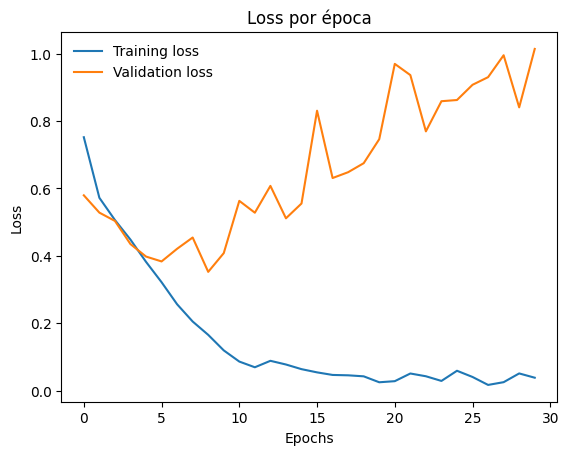

Acurracy: 85.90%
Precision (promedio ponderado): 0.86
Recall (promedio ponderado): 0.86
F1-score (promedio ponderado): 0.86
Matriz de Confusión:
[[800 200]
 [ 82 918]]


In [ ]:
model_profundo_96_adam = DEEP_CNN_96().to(device)

entrenar_y_validar(
    model_profundo_96_adam,
    train_loader_96,
    valid_loader_96,
    torch.optim.Adam(model_profundo_96_adam.parameters(), lr=1e-3),
    nn.CrossEntropyLoss(),
    device,
    30,
    "Modelo_Profundo_Adam_96"
)

accuracy, precision, recall, f1, conf_matrix = calcular_metricas(model_profundo_96_adam, test_loader_96, device)
guardar_metricas_csv("model_profundo_96_adam lr=1e-3", accuracy, precision, recall, f1, conf_matrix)


### 2.2.3 Análisis

Al aumentar la resolución de las imágenes de 32×32 a 96×96, se observan mejoras significativas en el desempeño del modelo. Con Adam, la precisión (accuracy) se estabiliza alrededor del 86% usando la resolución mayor, en comparación con aproximadamente un 79% al utilizar la resolución más baja. Por esta razón, se decidió emplear la resolución de 96×96 en las pruebas posteriores para aprovechar este beneficio.

No obstante, en ambos optimizadores se ha detectado un sobreajuste (overfitting) notable en los gráficos de pérdida (loss), especialmente al comparar las curvas de entrenamiento y validación. Para abordar este problema, se aplicarán ajustes tanto en el proceso de entrenamiento como en la arquitectura del modelo con el objetivo de reducir el overfitting y mejorar la generalización.

## 2.3 CNN Profunda 96x96 Regularizada + Adam y Early Stopping en el Entrenamiento

Basándonos en los análisis previos, se implementarán dos mejoras clave:

* **Early stopping** con un *patience* de 8, lo que significa que el entrenamiento se detendrá si no se observa mejora en la validación durante 8 épocas consecutivas. **(Debido a esto se aumentaràn el nùmero de èpocas de entrenamiento)**
* Mayor **regularización** en la arquitectura del modelo CNN profunda para reducir el sobreajuste.

Estas modificaciones buscan mejorar la generalización del modelo y evitar que se sobreentrene en los datos de entrenamiento.


### 2.3.1 CNN Modificada

In [ ]:
class DEEP_CNN_96_Regularized(nn.Module):
    def __init__(self):
        super(DEEP_CNN_96_Regularized, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),  # kernel más grande
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),  # dropout en feature maps
            nn.MaxPool2d(2),  # (32, 48, 48)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.15),
            nn.MaxPool2d(2),  # (64, 24, 24)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),  # (128, 12, 12)

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.25),
            nn.MaxPool2d(2),  # (256, 6, 6)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 256),  # menos parámetros que antes
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


### 2.3.2 Funcion Entrenamiento Modificada

In [ ]:
def entrenar_y_validar_regularizado(model, train_loader, valid_loader, optimizer, criterion, device, num_epochs, model_name, patience=8):
    train_losses = []
    valid_losses = []

    # Variables para Early Stopping
    best_valid_loss = float("inf")
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(1, num_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        # ======== FASE DE ENTRENAMIENTO ========
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        # ======== FASE DE VALIDACIÓN ========
        model.eval()
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)

        # Promedio de pérdidas
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Mostrar resultados
        print(f'Epoch {epoch}/{num_epochs} | Training Loss: {train_loss:.6f} | Validation Loss: {valid_loss:.6f}')

        # ======== EARLY STOPPING ========
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  → No mejora en {epochs_no_improve} época(s)")

        if epochs_no_improve >= patience:
            print(f"\n⏹ Early stopping activado en la época {epoch}")
            break

    # Restaurar mejor modelo encontrado
    model.load_state_dict(best_model_wts)

    # ======== GRAFICAR ========
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    plt.title("Loss por época")
    plt.show()

    guardar_grafico_loss(train_losses, valid_losses, model_name)

### 2.3.3 Modelo ADAM con lr 1e-3

Epoch 1/50 | Training Loss: 0.717174 | Validation Loss: 0.637348
Epoch 2/50 | Training Loss: 0.600377 | Validation Loss: 0.620973
Epoch 3/50 | Training Loss: 0.563713 | Validation Loss: 0.514902
Epoch 4/50 | Training Loss: 0.520016 | Validation Loss: 0.487293
Epoch 5/50 | Training Loss: 0.493600 | Validation Loss: 0.477278
Epoch 6/50 | Training Loss: 0.456457 | Validation Loss: 0.434965
Epoch 7/50 | Training Loss: 0.425301 | Validation Loss: 0.408380
Epoch 8/50 | Training Loss: 0.404321 | Validation Loss: 0.490306
  → No mejora en 1 época(s)
Epoch 9/50 | Training Loss: 0.365894 | Validation Loss: 0.385356
Epoch 10/50 | Training Loss: 0.340550 | Validation Loss: 0.371027
Epoch 11/50 | Training Loss: 0.294788 | Validation Loss: 0.358643
Epoch 12/50 | Training Loss: 0.262473 | Validation Loss: 0.357581
Epoch 13/50 | Training Loss: 0.245327 | Validation Loss: 0.383822
  → No mejora en 1 época(s)
Epoch 14/50 | Training Loss: 0.221830 | Validation Loss: 0.363377
  → No mejora en 2 época(s)
E

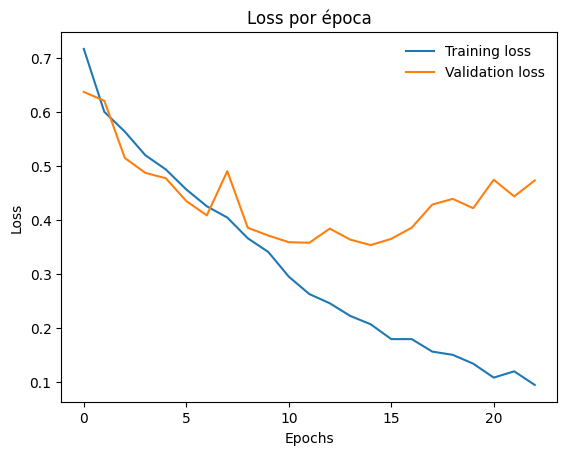

Acurracy: 84.50%
Precision (promedio ponderado): 0.85
Recall (promedio ponderado): 0.84
F1-score (promedio ponderado): 0.84
Matriz de Confusión:
[[819 181]
 [129 871]]


In [ ]:
model_profundo_96_adam_r1 = DEEP_CNN_96_Regularized().to(device)

entrenar_y_validar_regularizado(
    model_profundo_96_adam_r1,
    train_loader_96,
    valid_loader_96,
    torch.optim.Adam(model_profundo_96_adam_r1.parameters(), lr=1e-3),
    nn.CrossEntropyLoss(),
    device,
    50,
    "Modelo_Profundo_Adam_96 lr=1e-3"
)

accuracy, precision, recall, f1, conf_matrix = calcular_metricas(model_profundo_96_adam_r1, test_loader_96, device)
guardar_metricas_csv("model_profundo_96_adam lr=1e-3", accuracy, precision, recall, f1, conf_matrix)


#### 2.3.4 Modelo ADAM con lr 5e-4

Epoch 1/50 | Training Loss: 0.658175 | Validation Loss: 0.585869
Epoch 2/50 | Training Loss: 0.586996 | Validation Loss: 0.525452
Epoch 3/50 | Training Loss: 0.530061 | Validation Loss: 0.530159
  → No mejora en 1 época(s)
Epoch 4/50 | Training Loss: 0.492231 | Validation Loss: 0.462633
Epoch 5/50 | Training Loss: 0.450948 | Validation Loss: 0.430905
Epoch 6/50 | Training Loss: 0.418621 | Validation Loss: 0.429061
Epoch 7/50 | Training Loss: 0.386033 | Validation Loss: 0.402639
Epoch 8/50 | Training Loss: 0.341236 | Validation Loss: 0.405697
  → No mejora en 1 época(s)
Epoch 9/50 | Training Loss: 0.304911 | Validation Loss: 0.370825
Epoch 10/50 | Training Loss: 0.265807 | Validation Loss: 0.344317
Epoch 11/50 | Training Loss: 0.230785 | Validation Loss: 0.418931
  → No mejora en 1 época(s)
Epoch 12/50 | Training Loss: 0.199033 | Validation Loss: 0.377906
  → No mejora en 2 época(s)
Epoch 13/50 | Training Loss: 0.170414 | Validation Loss: 0.394974
  → No mejora en 3 época(s)
Epoch 14/50

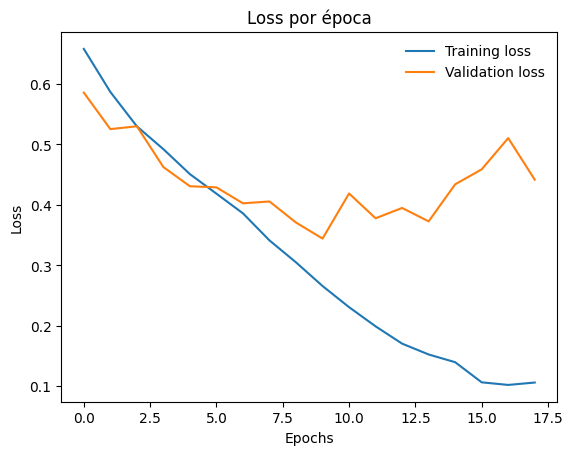

Acurracy: 83.60%
Precision (promedio ponderado): 0.84
Recall (promedio ponderado): 0.84
F1-score (promedio ponderado): 0.84
Matriz de Confusión:
[[815 185]
 [143 857]]


In [ ]:
model_profundo_96_adam_r2 = DEEP_CNN_96_Regularized().to(device)

entrenar_y_validar_regularizado(
    model_profundo_96_adam_r2,
    train_loader_96,
    valid_loader_96,
    torch.optim.Adam(model_profundo_96_adam_r2.parameters(), lr=5e-4),
    nn.CrossEntropyLoss(),
    device,
    50,
    "Modelo_Profundo_Adam_96 lr=5e-4"
)

accuracy, precision, recall, f1, conf_matrix = calcular_metricas(model_profundo_96_adam_r2, test_loader_96, device)
guardar_metricas_csv("model_profundo_96_adam lr=5e-4", accuracy, precision, recall, f1, conf_matrix)


#### 2.3.5 Modelo ADAM con lr 2e-4

Epoch 1/50 | Training Loss: 0.640852 | Validation Loss: 0.556436
Epoch 2/50 | Training Loss: 0.567788 | Validation Loss: 0.518024
Epoch 3/50 | Training Loss: 0.516088 | Validation Loss: 0.514275
Epoch 4/50 | Training Loss: 0.464304 | Validation Loss: 0.460598
Epoch 5/50 | Training Loss: 0.426046 | Validation Loss: 0.423925
Epoch 6/50 | Training Loss: 0.396672 | Validation Loss: 0.429122
  → No mejora en 1 época(s)
Epoch 7/50 | Training Loss: 0.361805 | Validation Loss: 0.398251
Epoch 8/50 | Training Loss: 0.313764 | Validation Loss: 0.410103
  → No mejora en 1 época(s)
Epoch 9/50 | Training Loss: 0.286688 | Validation Loss: 0.449724
  → No mejora en 2 época(s)
Epoch 10/50 | Training Loss: 0.257783 | Validation Loss: 0.366226
Epoch 11/50 | Training Loss: 0.213603 | Validation Loss: 0.413639
  → No mejora en 1 época(s)
Epoch 12/50 | Training Loss: 0.186751 | Validation Loss: 0.372287
  → No mejora en 2 época(s)
Epoch 13/50 | Training Loss: 0.162470 | Validation Loss: 0.431637
  → No mejo

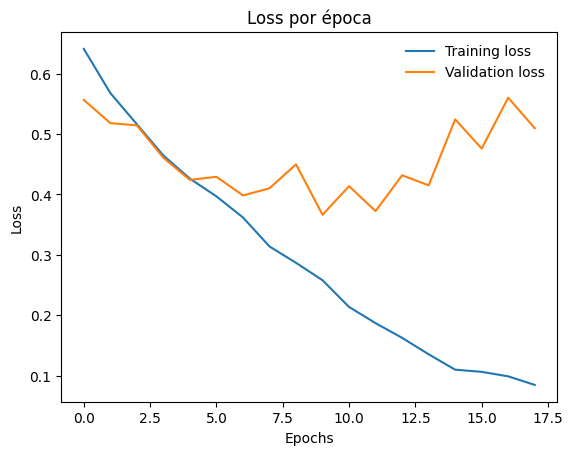

Acurracy: 82.55%
Precision (promedio ponderado): 0.83
Recall (promedio ponderado): 0.83
F1-score (promedio ponderado): 0.83
Matriz de Confusión:
[[843 157]
 [192 808]]


In [ ]:
model_profundo_96_adam_r3 = DEEP_CNN_96_Regularized().to(device)

entrenar_y_validar_regularizado(
    model_profundo_96_adam_r3,
    train_loader_96,
    valid_loader_96,
    torch.optim.Adam(model_profundo_96_adam_r3.parameters(), lr=2e-4),
    nn.CrossEntropyLoss(),
    device,
    50,
    "Modelo_Profundo_Adam_96 lr=2e-4"
)

accuracy, precision, recall, f1, conf_matrix = calcular_metricas(model_profundo_96_adam_r3, test_loader_96, device)
guardar_metricas_csv("model_profundo_96_adam lr=2e-4", accuracy, precision, recall, f1, conf_matrix)


## 2.4 CNN Profunda Final

Para el modelo final se incorporará una capa adicional para aumentar la profundidad de la red, con el objetivo de capturar características más complejas. Además, se utilizará la tasa de aprendizaje que previamente mostró los mejores resultados, buscando optimizar el desempeño sin comprometer la estabilidad del entrenamiento.

In [ ]:
class DEEP_CNN_96_Regularized_v2(nn.Module):
    def __init__(self):
        super(DEEP_CNN_96_Regularized_v2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.15),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.25),
            nn.MaxPool2d(2),

            # Capa adicional para más profundidad
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout2d(0.3),
            nn.AdaptiveAvgPool2d((1, 1))  # Reduce a (512, 1, 1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


Epoch 1/50 | Training Loss: 0.695398 | Validation Loss: 0.593123
Epoch 2/50 | Training Loss: 0.588011 | Validation Loss: 0.518438
Epoch 3/50 | Training Loss: 0.549964 | Validation Loss: 0.500914
Epoch 4/50 | Training Loss: 0.514515 | Validation Loss: 0.490893
Epoch 5/50 | Training Loss: 0.470429 | Validation Loss: 0.429695
Epoch 6/50 | Training Loss: 0.449555 | Validation Loss: 0.452090
  → No mejora en 1 época(s)
Epoch 7/50 | Training Loss: 0.403103 | Validation Loss: 0.403584
Epoch 8/50 | Training Loss: 0.382641 | Validation Loss: 0.423588
  → No mejora en 1 época(s)
Epoch 9/50 | Training Loss: 0.349349 | Validation Loss: 0.387302
Epoch 10/50 | Training Loss: 0.317635 | Validation Loss: 0.380635
Epoch 11/50 | Training Loss: 0.306067 | Validation Loss: 0.401097
  → No mejora en 1 época(s)
Epoch 12/50 | Training Loss: 0.255597 | Validation Loss: 0.394101
  → No mejora en 2 época(s)
Epoch 13/50 | Training Loss: 0.236085 | Validation Loss: 0.346263
Epoch 14/50 | Training Loss: 0.215000 |

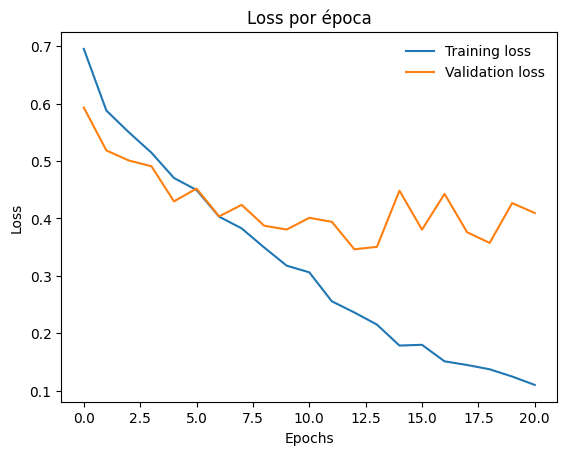

Acurracy: 85.60%
Precision (promedio ponderado): 0.86
Recall (promedio ponderado): 0.86
F1-score (promedio ponderado): 0.86
Matriz de Confusión:
[[864 136]
 [152 848]]


In [ ]:
model_profundo_96_adam_r4 = DEEP_CNN_96_Regularized().to(device)

entrenar_y_validar_regularizado(
    model_profundo_96_adam_r4,
    train_loader_96,
    valid_loader_96,
    torch.optim.Adam(model_profundo_96_adam_r4.parameters(), lr=1e-3),
    nn.CrossEntropyLoss(),
    device,
    50,
    "Modelo_Profundo_Adam_96 lr=1e-3"
)

accuracy, precision, recall, f1, conf_matrix = calcular_metricas(model_profundo_96_adam_r4, test_loader_96, device)
guardar_metricas_csv("model_profundo_96_adam lr=1e-3", accuracy, precision, recall, f1, conf_matrix)


# 3. Modelo Pre-Entrenado ResNet18

En esta sección se implementará el fine-tuning de un modelo ResNet18 preentrenado. Fine-tuning consiste en tomar un modelo previamente entrenado en una gran cantidad de datos (por ejemplo, ImageNet) y adaptarlo a nuestro problema específico, ajustando sus pesos para mejorar el rendimiento en nuestra tarea concreta.

Se limitará el entrenamiento a solo 5 épocas para aprovechar la capacidad ya aprendida del modelo y evitar sobreajuste, además de reducir el tiempo computacional. Esta estrategia es común cuando se trabaja con modelos preentrenados, ya que usualmente requieren menos tiempo para converger debido a que ya cuentan con representaciones robustas.

In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    return avg_loss

def evaluate(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(valid_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

num_epochs = 5 #30
train_losses = []
valid_losses = []
valid_accuracies = []

# Cargar el modelo preentrenado ResNet18
model_resnet = models.resnet18(pretrained=True)

# Cambiar la última capa para clasificación binaria (gatos vs perros)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 2)

# Mover el modelo al dispositivo (GPU o CPU)
model_resnet = model_resnet.to(device)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss = train(model_resnet, train_loader_96, optimizer, criterion, device)
    valid_loss, valid_accuracy = evaluate(model_resnet, valid_loader_96, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}")
    print(f"Validation Accuracy: {valid_accuracy:.2f}%")

guardar_grafico_loss(train_losses, valid_losses, "ResNet18")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s] 



Epoch 1/5
Training Loss: 0.2358
Validation Loss: 0.1650
Validation Accuracy: 93.67%

Epoch 2/5
Training Loss: 0.0545
Validation Loss: 0.2289
Validation Accuracy: 92.67%

Epoch 3/5
Training Loss: 0.0218
Validation Loss: 0.2113
Validation Accuracy: 93.67%

Epoch 4/5
Training Loss: 0.0214
Validation Loss: 0.2444
Validation Accuracy: 93.25%

Epoch 5/5
Training Loss: 0.0138
Validation Loss: 0.2687
Validation Accuracy: 93.17%


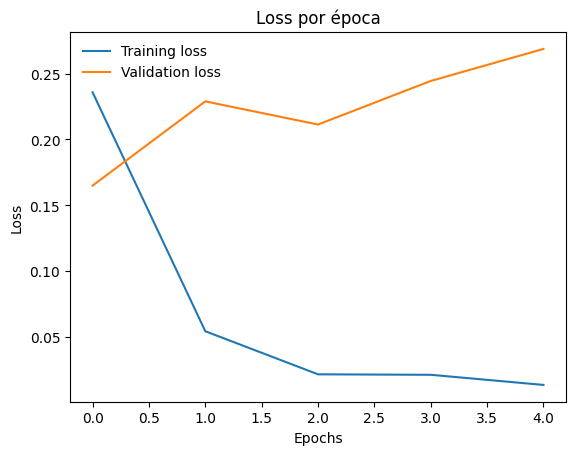

In [ ]:
# Graficar las pérdidas de entrenamiento y validación por época
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.title("Loss por época")
plt.show()

## 3.1 Metricas Modelo Resnet18

In [ ]:
accuracy, precision, recall, f1, conf_matrix = calcular_metricas(model_resnet, test_loader_96, device)
guardar_metricas_csv("model_resnet", accuracy, precision, recall, f1, conf_matrix)

Acurracy: 94.15%
Precision (promedio ponderado): 0.94
Recall (promedio ponderado): 0.94
F1-score (promedio ponderado): 0.94
Matriz de Confusión:
[[947  53]
 [ 64 936]]
